[Part I: On-policy learning and SARSA (3 points)](#Part-I:-On-policy-learning-and-SARSA-(3-points))

[Part II: Experience replay (4 points)](#Part-II:-experience-replay-(4-points))

[Bonus I: TD($ \lambda $) (5+ points)](#Bonus-I:-TD($\lambda$)-(5+-points))

[Bonus II: More pacman (5+ points)](#Bonus-II:-More-pacman-(5+-points))

## Part I: On-policy learning and SARSA (3 points)

_This notebook builds upon `qlearning.ipynb`, or to be exact, generating qlearning.py._

The policy we're gonna use is epsilon-greedy policy, where agent takes optimal action with probability $(1-\epsilon)$, otherwise samples action at random. Note that agent __can__ occasionally sample optimal action during random sampling by pure chance.

In [1]:
# In google collab, uncomment this:
# !wget https://bit.ly/2FMJP5K -q -O setup.py
# !bash setup.py 2>&1 1>stdout.log | tee stderr.log

# This code creates a virtual display to draw game images on.
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

Now you can use code, generated from seminar `seminar_qlearning.ipynb`. Or just copy&paste it.

In [13]:
# %%writefile qlearning.py
from collections import defaultdict
import random
import math
import numpy as np


class QLearningAgent:
    def __init__(self, learning_rate_alpha, exploration_prob_epsilon, discount_gamma, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.exploration_prob (aka epsilon for epsilon-greedy)
          - self.learning_rate (aka alpha)
          - self.discount (aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0.))
        self.learning_rate = learning_rate_alpha
        self.exploration_prob = exploration_prob_epsilon
        self.discount = discount_gamma

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)
        if not possible_actions:
            # terminate state, it's value = 0.
            return 0.
        
        action_values = self._qvalues[state]
        value = max(action_values[action] for action in possible_actions)
        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        r, gamma, alpha = reward, self.discount, self.learning_rate
        Qsa = self._qvalues[state][action]
        Vns = self.get_value(next_state)

        new_qvalue = (1 - alpha) * Qsa + alpha * (r + gamma * Vns)
        self.set_qvalue(state, action, new_qvalue)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)
        if not possible_actions:
            # terminate state, no actions
            return None

        best_action, best_value = None, None
        action_values = self._qvalues[state]
        for action in possible_actions:
            value = action_values[action]
            if best_action is None or value > best_value:
                best_action, best_value = action, value
        
        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.exploration_prob, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        possible_actions = self.get_legal_actions(state)
        if not possible_actions:
            return None

        # agent parameters:
        epsilon = self.exploration_prob
        action = None
        
        if np.random.uniform(low=0., high=1.) <= epsilon:
            action = np.random.choice(possible_actions)
        else:
            action = self.get_best_action(state)

        return action

In [22]:
class EVSarsaAgent(QLearningAgent):
    """ 
    An agent that changes some of q-learning functions to implement Expected Value SARSA. 
    Note: this demo assumes that your implementation of QLearningAgent.update uses get_value(next_state).
    If it doesn't, please add
        def update(self, state, action, reward, next_state):
            and implement it for Expected Value SARSA's V(s')
    """

    def get_value(self, state):
        """ 
        Returns Vpi for current state under epsilon-greedy policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}

        Hint: all other methods from QLearningAgent are still accessible.
        """
        epsilon = self.exploration_prob
        possible_actions = self.get_legal_actions(state)
        if not possible_actions:
            # terminate state, it's value = 0.
            return 0.
        
        action_values = self._qvalues[state]
        value = sum(action_values[action] for action in possible_actions) * epsilon / len(possible_actions)
        value += max(action_values[action] for action in possible_actions) * (1 - epsilon)
        return value

In [59]:
from scipy.special import softmax

class EVSarsaAgentSoftmax(QLearningAgent):
    """ 
    An agent that changes some of q-learning functions to implement Expected Value SARSA. 
    Note: this demo assumes that your implementation of QLearningAgent.update uses get_value(next_state).
    If it doesn't, please add
        def update(self, state, action, reward, next_state):
            and implement it for Expected Value SARSA's V(s')
    """

    def get_value(self, state):
        """ 
        Returns Vpi for current state under epsilon-greedy policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}

        Hint: all other methods from QLearningAgent are still accessible.
        """
        epsilon = self.exploration_prob
        possible_actions = self.get_legal_actions(state)
        if not possible_actions:
            # terminate state, it's value = 0.
            return 0.
        
        action_values = self._qvalues[state]
        action_values = np.array([action_values[action] for action in possible_actions])
        probs = softmax(action_values) * (1 - epsilon) + np.full(len(possible_actions), epsilon / len(possible_actions))
        value = np.dot(probs, action_values)
        return value

### Cliff World

Let's now see how our algorithm compares against q-learning in case where we force agent to explore all the time.

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/cliffworld.png width=600>
<center><i>image by cs188</i></center>

In [34]:
import gym
import gym.envs.toy_text
env = gym.envs.toy_text.CliffWalkingEnv()
n_actions = env.action_space.n
possible_actions = list(range(n_actions))

print(env.__doc__)


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf

    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    


In [35]:
# Our cliffworld has one difference from what's on the image: there is no wall.
# Agent can choose to go as close to the cliff as it wishes. x:start, T:exit, C:cliff, o: flat ground
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [36]:
def play_and_train(env, agent, t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

Sarsa: -15.1 Q-learning: -13.433333333333334 Softmax: -13.333333333333334


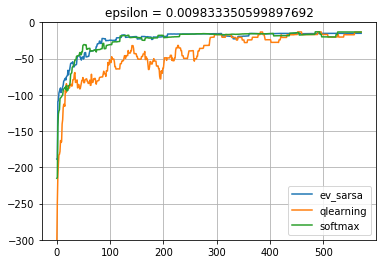

In [65]:
agent_sarsa = EVSarsaAgent(
    learning_rate_alpha=0.25, exploration_prob_epsilon=0.2, discount_gamma=0.99,
    get_legal_actions=lambda s: possible_actions
)
agent_ql = QLearningAgent(
    learning_rate_alpha=0.25, exploration_prob_epsilon=0.2, discount_gamma=0.99,
    get_legal_actions=lambda s: possible_actions
)
agent_softmax = EVSarsaAgentSoftmax(
    learning_rate_alpha=0.25, exploration_prob_epsilon=0.2, discount_gamma=0.99,
    get_legal_actions=lambda s: possible_actions
)

from IPython.display import clear_output
from pandas import DataFrame


def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

rewards_sarsa, rewards_ql, rewards_softmax = [], [], []
k = 30

for i in range(601):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    rewards_softmax.append(play_and_train(env, agent_softmax))
    # Note: agent.epsilon stays constant
    
    decay = .995
    agent_ql.exploration_prob *= decay
    agent_sarsa.exploration_prob *= decay
    agent_softmax.exploration_prob *= decay

    if i % k == 0:
        clear_output(True)
        print('Sarsa:', np.mean(rewards_sarsa[-k:]), 'Q-learning:', np.mean(rewards_ql[-k:]), 'Softmax:', np.mean(rewards_softmax[-k:]))
        plt.title("epsilon = %s" % agent_ql.exploration_prob)
        plt.plot(moving_average(rewards_sarsa, k), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql, k), label='qlearning')
        plt.plot(moving_average(rewards_softmax, k), label='softmax')
        plt.grid()
        plt.legend()
        plt.ylim(-300, 0)
        plt.show()

Let's now see what did the algorithms learn by visualizing their actions at every state.

In [51]:
def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env._cliff.shape

    actions = '^>v<'

    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.get_best_action(yi * n_cols + xi)], end='')
        print()

In [52]:
print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

Q-Learning
 >  >  >  >  >  >  v  >  >  >  v  v 
 >  v  >  v  >  >  v  >  >  v  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


### More on SARSA

Here are some of the things you can do if you feel like it:

* Play with epsilon. See learned how policies change if you set epsilon to higher/lower values (e.g. 0.75).
* Expected Value SASRSA for softmax policy __(2pts)__:
$$ \pi(a_i|s) = softmax({Q(s,a_i) \over \tau}) = {e ^ {Q(s,a_i)/ \tau}  \over {\sum_{a_j}  e ^{Q(s,a_j) / \tau }}} $$
* Implement N-step algorithms and TD($\lambda$): see [Sutton's book](http://incompleteideas.net/book/bookdraft2018jan1.pdf) chapter 7 and chapter 12.
* Use those algorithms to train on CartPole in previous / next assignment for this week.

## Part II: experience replay (4 points)

There's a powerful technique that you can use to improve sample efficiency for off-policy algorithms: [spoiler] Experience replay :)

The catch is that you can train Q-learning and EV-SARSA on `<s,a,r,s'>` tuples even if they aren't sampled under current agent's policy. So here's what we're gonna do:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png width=480>

#### Training with experience replay
1. Play game, sample `<s,a,r,s'>`.
2. Update q-values based on `<s,a,r,s'>`.
3. Store `<s,a,r,s'>` transition in a buffer. 
 3. If buffer is full, delete earliest data.
4. Sample K such transitions from that buffer and update q-values based on them.


To enable such training, first we must implement a memory structure that would act like such a buffer.

In [66]:
# In google collab, uncomment this:
# !wget https://bit.ly/2FMJP5K -q -O setup.py
# !bash setup.py 2>&1 1>stdout.log | tee stderr.log

# This code creates a virtual display to draw game images on.
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [108]:
import random


class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = np.empty(size, dtype=np.object)
        self._maxsize = size
        self._is_full = False
        self._tail = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        self._storage[self._tail] = data
        self._tail = (self._tail + 1) % self._maxsize
        
        if not self._is_full and self._tail == 0:
            self._is_full = True

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        
        storage = self._storage if self._is_full else self._storage[:self._tail]
        samples = np.random.choice(storage, size=batch_size)
#         samples = tuple(map(np.array, zip(*samples)))

        return samples

Some tests to make sure your buffer works right

In [95]:
def obj2arrays(obj):
    for x in obj:
        yield np.array([x])

def obj2sampled(obj):
    return tuple(obj2arrays(obj))

replay = ReplayBuffer(2)
obj1 = (0, 1, 2, 3, True)
obj2 = (4, 5, 6, 7, False)
replay.add(*obj1)
assert replay.sample(1) == obj2sampled(obj1), "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(replay) == 2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay) == 2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2sampled(obj2)
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100)) == 2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2sampled(obj1)
print("Success!")

Success!


Now let's use this buffer to improve training:

In [97]:
import gym

env = gym.make("Taxi-v2")
n_actions = env.action_space.n
possible_actions = list(range(n_actions))

In [109]:
def play_and_train_with_replay(
    env, agent, replay=None, t_max=10**4, replay_batch_size=32
):
    """
    This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward
    :param replay: ReplayBuffer where agent can store and sample (s,a,r,s',done) tuples.
        If None, do not use experience replay
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        a = agent.get_action(s)
        next_s, r, done, _ = env.step(a)

        agent.update(s, a, r, next_s)

        if replay is not None:
            replay.add(s, a, r, next_s, done)

            # sample replay_batch_size random transitions from replay,
            # then update agent on each of them in a loop
            for s_, a_, r_, next_s_, done_ in replay.sample(replay_batch_size):
                agent.update(s_, a_, r_, next_s_)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

Sarsa: -6.333333333333333 Q-learning: -9.9 Softmax: -6.2 Exp Replay: -9.7


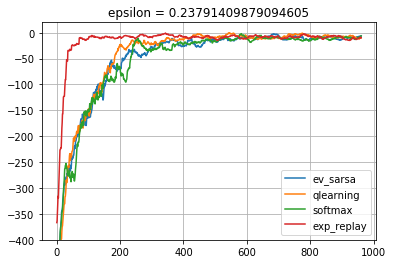

In [118]:
from IPython.display import clear_output

agent_sarsa = EVSarsaAgent(learning_rate_alpha=0.5, exploration_prob_epsilon=0.25, discount_gamma=0.99, get_legal_actions=lambda s: possible_actions)
agent_ql = QLearningAgent(learning_rate_alpha=0.5, exploration_prob_epsilon=0.25, discount_gamma=0.99, get_legal_actions=lambda s: possible_actions)
agent_softmax = EVSarsaAgentSoftmax(learning_rate_alpha=0.5, exploration_prob_epsilon=0.25, discount_gamma=0.99, get_legal_actions=lambda s: possible_actions)
agent_exp_replay = QLearningAgent(learning_rate_alpha=0.5, exploration_prob_epsilon=0.25, discount_gamma=0.99, get_legal_actions=lambda s: possible_actions)
replay = ReplayBuffer(10000)

def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

rewards_sarsa, rewards_ql, rewards_softmax, rewards_exp_replay = [], [], [], []
k = 30

for i in range(1001):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    rewards_softmax.append(play_and_train(env, agent_softmax))
    rewards_exp_replay.append(play_and_train_with_replay(env, agent_exp_replay, replay=replay))
    
    decay = .99995
    agent_ql.exploration_prob *= decay
    agent_sarsa.exploration_prob *= decay
    agent_softmax.exploration_prob *= decay

    if i % k == 0:
        clear_output(True)
        print('Sarsa:', np.mean(rewards_sarsa[-k:]), 'Q-learning:', np.mean(rewards_ql[-k:]), 'Softmax:', np.mean(rewards_softmax[-k:]), 'Exp Replay:', np.mean(rewards_exp_replay[-k:]))
        plt.title("epsilon = %s" % agent_ql.exploration_prob)
        plt.plot(moving_average(rewards_sarsa, k), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql, k), label='qlearning')
        plt.plot(moving_average(rewards_softmax, k), label='softmax')
        plt.plot(moving_average(rewards_exp_replay, k), label='exp_replay')
        plt.grid()
        plt.legend()
        plt.ylim(-400, 20)
        plt.show()

#### What to expect:

Experience replay, if implemented correctly, will improve algorithm's initial convergence a lot, but it shouldn't affect the final performance.

### Outro

We will use the code you just wrote extensively in the next week of our course. If you're feeling that you need more examples to understand how experience replay works, try using it for binarized state spaces (CartPole or other __[classic control envs](https://gym.openai.com/envs/#classic_control)__).

__Next week__ we're gonna explore how q-learning and similar algorithms can be applied for large state spaces, with deep learning models to approximate the Q function.

However, __the code you've written__ for this week is already capable of solving many RL problems, and as an added benifit - it is very easy to detach. You can use Q-learning, SARSA and Experience Replay for any RL problems you want to solve - just thow 'em into a file and import the stuff you need.

### Bonus I: TD($\lambda$) (5+ points)

There's a number of advanced algorithms you can find in week 3 materials (Silver lecture II and/or reading about eligibility traces). One such algorithm is TD(lambda), which is based on the idea of eligibility traces. You can also view it as a combination of N-step updates for alll N.
* N-step temporal difference from Sutton's book - [url](http://incompleteideas.net/book/the-book-2nd.html), page 142 / chapter 7 
* Eligibility traces from Sutton's book - same url, chapter 12 / page 278
* Blog post on eligibility traces - [url](http://pierrelucbacon.com/traces/)

Here's a practical algorithm you can start with: [url](https://stackoverflow.com/questions/40862578/how-to-understand-watkinss-q%CE%BB-learning-algorithm-in-suttonbartos-rl-book/40892302)


Implementing this algorithm will prove more challenging than q-learning or sarsa, but doing so will earn you a deeper understanding of how value-based methods work [in addition to some bonus points].

More kudos for comparing and analyzing TD($\lambda$) against Q-learning and EV-SARSA in different setups (taxi vs cartpole, constant epsilon vs decreasing epsilon).

### Bonus II: More pacman (5+ points)

__see README.md for software requirements of seminar_py2__

Remember seminar_py2 where your vanilla q-learning had hard time solving Pacman even on a small grid? Now's the time to fix that issue.

We'll focus on those grids for pacman setup.
* python pacman.py -p PacmanQAgent -x N_TRAIN_GAMES -n N_TOTAL_GAMES -l __mediumGrid__
* python pacman.py -p PacmanQAgent -x N_TRAIN_GAMES -n N_TOTAL_GAMES -l __mediumClassic__

Even if you adjust N_TRAIN_GAMES to 10^5 and N_TOTAL_GAMES to 10^5+100 (100 last games are for test), pacman won't solve those environments

The problem with those environments is that they have a large amount of unique states. However, you can devise a smaller environment state by choosing different observation parameters, e.g.:
 * distance and direction to nearest ghost
 * where is nearest food
 * 'center of mass' of all food points (and variance, and whatever)
 * is there a wall in each direction
 * and anything else you see fit 
 
Here's how to get this information from [state](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/pacman.py#L49),
 * Get pacman position: [state.getPacmanPosition()](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/pacman.py#L128)
 * Is there a wall at (x,y)?: [state.hasWall(x,y)](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/pacman.py#L189)
 * Get ghost positions: [state.getGhostPositions()](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/pacman.py#L144)
 * Get all food positions: [state.getCapsules()](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/pacman.py#L153)
 
You can call those methods anywhere you see state.
 * e.g. in [agent.getValue(state)](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/qlearningAgents.py#L52)
 * Defining a function that extracts all features and calling it in [getQValue](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/qlearningAgents.py#L38) and [setQValue](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/qlearningAgents.py#L44) is probably enough.
 * You can also change agent parameters. The simplest way is to hard-code them in [PacmanQAgent](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/qlearningAgents.py#L140)

Also, don't forget to optimize ```learning_rate```, ```discount``` and ```epsilon``` params of model, this may also help to solve this env.